In [1]:
#Import the libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../data/Binance_BTCUSDT_d.csv', sep=",")
df = df[['date', 'low', 'high']]
df.shape

(1364, 3)

In [3]:
for i in range(len(df['date'])):
    df['date'][i] = df['date'][i][:10]

df = df.sort_values('date')

<ipython-input-3-4e12f19fe07d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] = df['date'][i][:10]


In [4]:
high_prices = df.loc[:,'high'].to_numpy()
low_prices = df.loc[:,'low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0
mid_prices = mid_prices.reshape(-1,1)

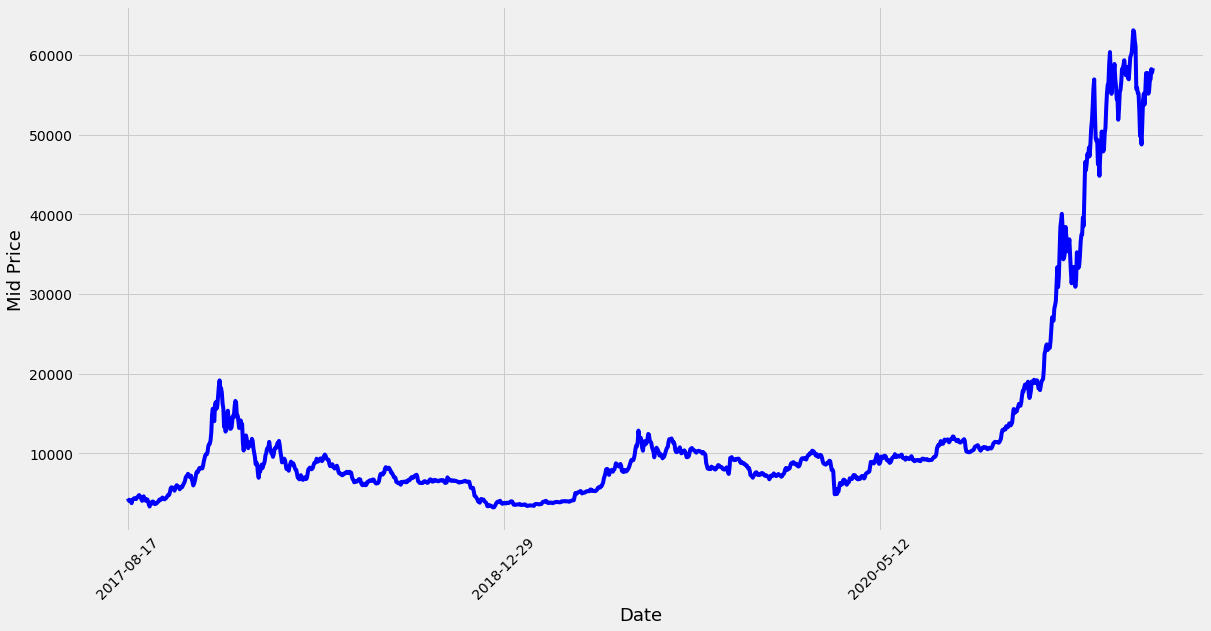

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0, color='b')
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
#plt.ylim((0,130))
plt.show()

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1))
cut_data=1 
#cut_data = math.ceil(len(mid_prices) *.9)
mid_prices = mid_prices[cut_data:]
scaled_data = scaler.fit_transform(mid_prices)
print(mid_prices.shape)

(1363, 1)


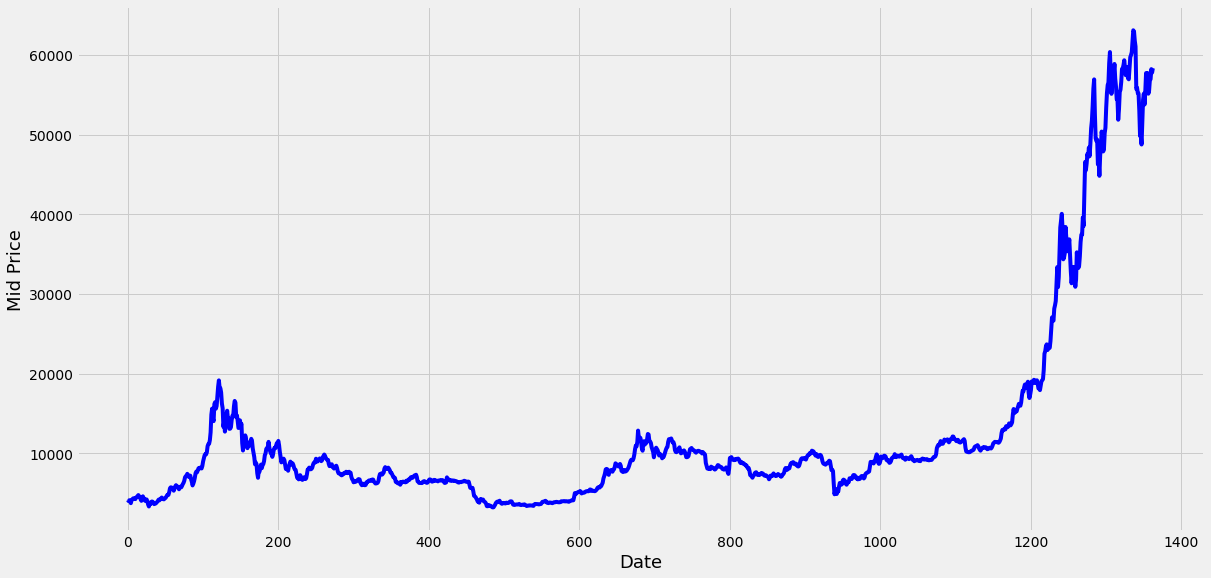

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(0,len(mid_prices)),mid_prices, color='b')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
#plt.ylim((0,130))
plt.show()

In [8]:
train_dataset_length = math.ceil(len(mid_prices) * .95)
print(train_dataset_length)

1295


In [9]:
train_data = scaled_data[0:train_dataset_length  , : ]

#Splitting the data
x_train=[]
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])



In [10]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [11]:
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))


# Adding a fourth LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fifth LSTM layer and and Dropout layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(units = 1))

In [12]:
#compile and fit the model on 30 epochs
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 30, batch_size = 100)

Epoch 1/30
13/13 [==============================] - 18s 19ms/step - loss: 0.0222
Epoch 2/30
13/13 [==============================] - 0s 20ms/step - loss: 0.0083
Epoch 3/30
13/13 [==============================] - 0s 18ms/step - loss: 0.0025
Epoch 4/30
13/13 [==============================] - 0s 17ms/step - loss: 0.0011
Epoch 5/30
13/13 [==============================] - 0s 17ms/step - loss: 0.0011
Epoch 6/30
13/13 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 7/30
13/13 [==============================] - 0s 18ms/step - loss: 0.0011
Epoch 8/30
13/13 [==============================] - 0s 17ms/step - loss: 0.0013
Epoch 9/30
13/13 [==============================] - 0s 17ms/step - loss: 0.0013
Epoch 10/30
13/13 [==============================] - 0s 17ms/step - loss: 8.7753e-04
Epoch 11/30
13/13 [==============================] - 0s 18ms/step - loss: 9.1632e-04
Epoch 12/30
13/13 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 13/30
13/13 [=========

In [13]:
#Test data set
test_data = scaled_data[train_dataset_length - 10 : , : ]

#splitting the x_test and y_test data sets
x_test = []
y_test =  mid_prices[train_dataset_length : , : ] 

print(test_data.shape)

for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])
   
    
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into 3-D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#print(x_test,"test",y_test)
x_test.shape

(78, 1)


(68, 10, 1)

In [14]:
#check predicted values
predictions = model.predict(x_test) 
#Undo scaling
predictions_real = scaler.inverse_transform(predictions)
predictions_real1 = predictions_real

#Calculate RMSE score
rmse=np.sqrt(np.mean(((predictions_real- y_test)**2)))

print("RMSE: ",rmse)
#print( " last x_test results: ", x_test[len(x_test)-1])
#print("last predictions: ",predictions[len(predictions)-10:len(predictions)])
#print("last predictions: ",predictions)
#print("shapes test, pred ",x_test.shape, predictions.shape, y_test)

RMSE:  4098.238283448305


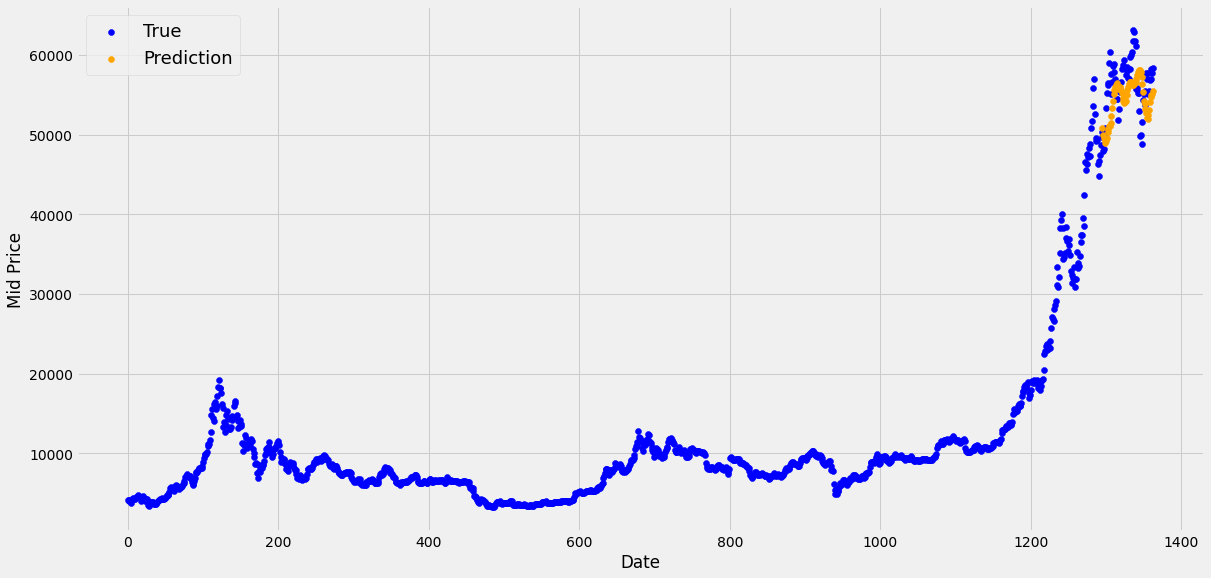

In [15]:
plt.figure(figsize = (18,9))
plt.scatter(range(0,len(mid_prices),1),mid_prices,color='b',label='True')
#plt.scatter(range(0,len(predictions),1),mid_prices[train_dataset_length:],color='b',label='True')
plt.scatter(range(len(mid_prices)-len(predictions),len(mid_prices),1),predictions_real,color='orange', label='Prediction')
#plt.plot(predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()




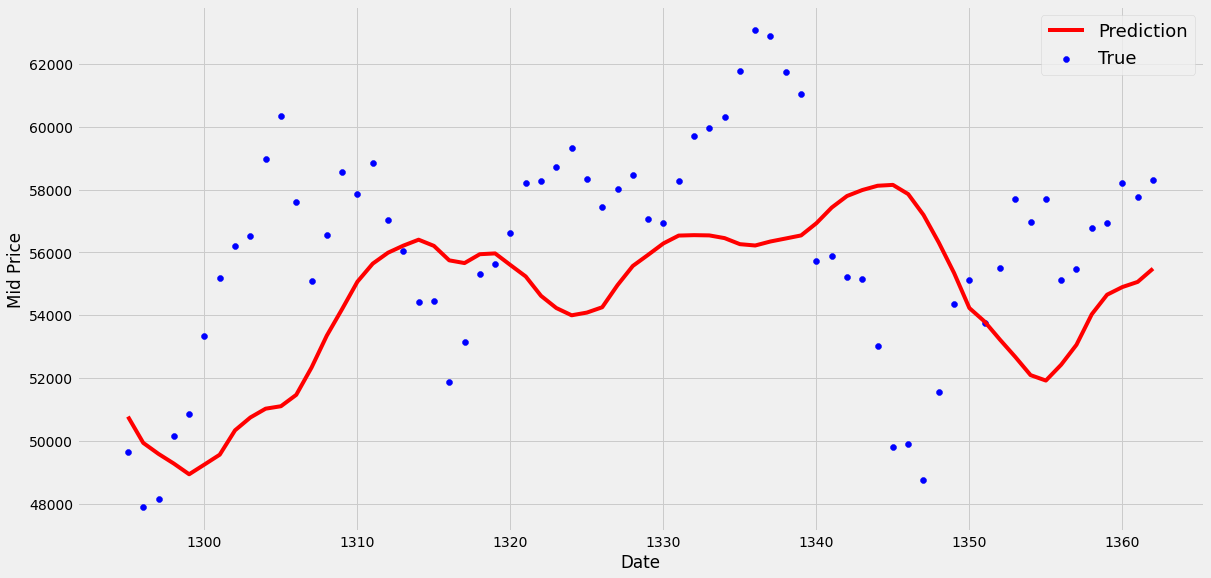

In [16]:
plt.figure(figsize = (18,9))
#plt.scatter(range(0,len(mid_prices),1),mid_prices,color='b',label='True')
plt.scatter(range(len(mid_prices)-len(predictions),len(mid_prices),1),mid_prices[train_dataset_length:],color='b',label='True')
#plt.scatter(range(len(mid_prices)-len(predictions),len(mid_prices),1),predictions_real,color='orange', label='Prediction')
plt.plot(range(len(mid_prices)-len(predictions),len(mid_prices),1),predictions_real,color='red', label='Prediction')
#plt.plot(predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [17]:
np.savetxt("../data/testing.csv", y_test, delimiter=",")


In [18]:
counter = 0
while counter < 30:
    df = pd.read_csv('../data/testing.csv', sep=",")
    print(df.tail())
    df = np.array(df)
    print(df.shape)
#scaled_data = scaler.fit_transform(mid_prices)
    scaled_data = scaler.fit_transform(df)
    test_data = scaled_data[ : , : ]

    print(test_data.shape)

#splitting the x_test and y_test data sets
    x_test = []


    for i in range(10,len(test_data)):
        x_test.append(test_data[i-10:i,0])
   
    
    
#Convert x_test to a numpy array 
    x_test = np.array(x_test)

#Reshape the data into 3-D array
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    predictions = model.predict(x_test) 
#Undo scaling
    predictions_real = scaler.inverse_transform(predictions)

    f=open('../data/testing.csv','ab')
    a= predictions_real[len(predictions_real)-1:]
    np.savetxt(f,a)
    f.close()
    counter += 1

    4.963694000000000233e+04
62                 56780.000
63                 56945.815
64                 58200.000
65                 57767.830
66                 58309.250
(67, 1)
(67, 1)
    4.963694000000000233e+04
63              56945.815000
64              58200.000000
65              57767.830000
66              58309.250000
67              57382.351562
(68, 1)
(68, 1)
    4.963694000000000233e+04
64              58200.000000
65              57767.830000
66              58309.250000
67              57382.351562
68              57670.789062
(69, 1)
(69, 1)
    4.963694000000000233e+04
65              57767.830000
66              58309.250000
67              57382.351562
68              57670.789062
69              57456.453125
(70, 1)
(70, 1)
    4.963694000000000233e+04
66              58309.250000
67              57382.351562
68              57670.789062
69              57456.453125
70              57431.421875
(71, 1)
(71, 1)
    4.963694000000000233e+04
67              57382

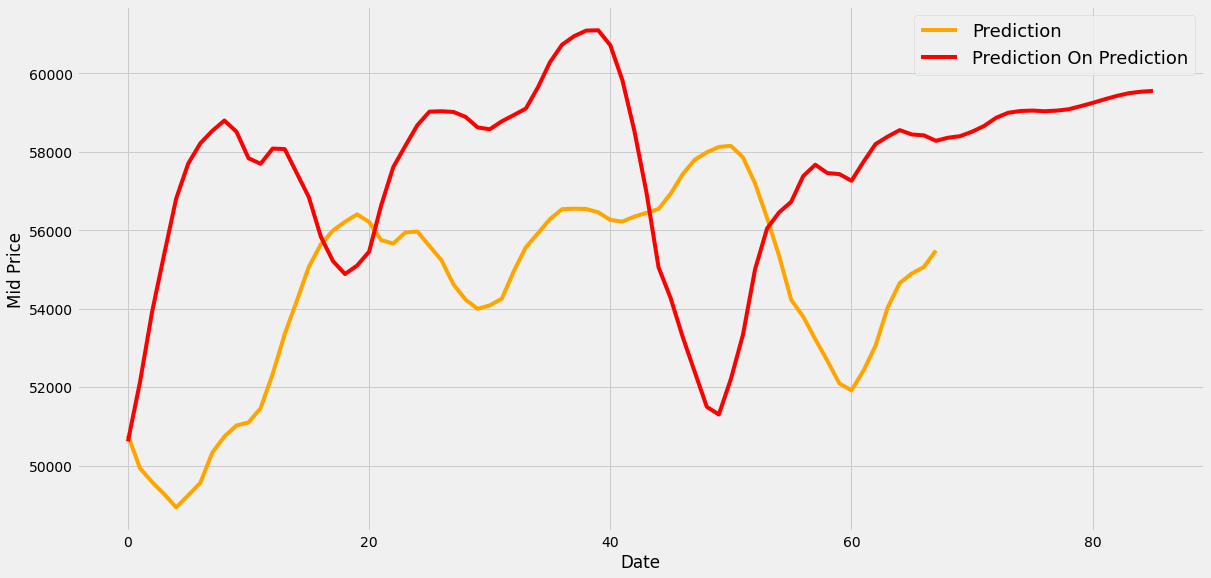

In [20]:
plt.figure(figsize = (18,9))
#plt.scatter(range(0,len(mid_prices),1),mid_prices,color='b',label='True')
#plt.scatter(range(0,len(mid_prices)),mid_prices,color='b',label='True')
plt.plot(predictions_real1,color='orange', label='Prediction')
plt.plot(predictions_real,color='red', label='Prediction On Prediction')
#plt.plot(predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()